In [1]:
import pandas as pd
import Auxiliary
import torch

In [2]:
path = '../dataset/graph/'
with open(path + "ddidpi.nt") as f:
    lines = f.readlines()


def save_graph(path, line):
    with open(path + 'ddidpi_v1.ttl', 'a') as file:
        file.write(line)


def preprocess_v1(lines):
    for line in lines:
        s = line.split(' ')[0]
        p = line.split(' ')[1]
        o = '_'.join(line.split(' ')[2:])
        save_graph('V1/', s + '\t' + p + '\t' + o)


def preprocess_v2(lines):
    for line in lines:
        a = line.replace('>.', '>')
        a = a.replace('<http://www.project-ddidpi.de/DPI/', '')
        a = a.replace('<http://purl.uniprot.org/pubmed/', 'pubmed:')
        a = a.replace('<http://www.project-ddidpi.de/vocab/DPI>', 'DPI')
        a = a.replace('<http://www.project-ddidpi.de/vocab/', '')
        a = a.replace('<http://www.w3.org/1999/02/22-rdf-syntax-ns#', '')
        a = a.replace('<http://www.project-ddidpi.de/DDI/', '')
        a = a.replace('^^<http://www.w3.org/2001/XMLSchema#string', '')
        a = a.replace('<http://www.project-ddidpi.de/Drug/', 'Drug:') 

        a = a.replace('<http://purl.uniprot.org/uniprot/', 'uniprot:') 
        a = a.replace('<http://dbpedia.org/resource/', '') 
        a = a.replace('<http://www.project-ddidpi.de/Annotation/', '') 
        a = a.replace('<http://www.project-ddidpi.de/Protein/', 'Protein:') 
        a = a.replace('<http://purl.uniprot.org/geneid/', 'gene:') 

        a = a.replace('>', '')
        preprocess_v1([a])
#         save_graph('V1/', a)

In [3]:
preprocess_v2(lines)

In [4]:
Auxiliary.pipeline_kge('config.csv')

Training epochs on cuda:   0%|          | 0/30 [00:00<?, ?epoch/s]

INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=16.


Evaluating on cuda:   0%|          | 0.00/659k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 16968.14s seconds


In [3]:
path = 'V1/'
kg = pd.read_csv(path + 'ddidpi_v1.ttl', sep='\t', header=None)
display(kg.shape, kg.head(2))

(3296251, 3)

,0,1,2
0,DB00001-P00734,type,DPI
1,DB00001-P00734,hasPubMedID,pubmed:10505536


# Unsupervised Learning¶
#### Save Learned Embeddings

In [4]:
m = 'TransH'  #RotatE
fold=1


# path = '../Cancer_treatment/Embeddings/KG versions/V4/Uniform/G2/'
print(path)
model = torch.load(path + m + str(fold) + '/trained_model.pkl', map_location='cpu')


#model = torch.load('G/QuatE5/trained_model.pkl', map_location='cpu') #QuatE1
entity_embedding_tensor, relation_embedding_tensor =  Auxiliary.get_learned_embeddings(model)

V1/


## Computing clusters of the predicted heads by the model. Visualize PCA Projection to 2D
#### Creating dataframe with the embeddings predicted entities

In [7]:
tf_dataset, triple_dataset = Auxiliary.load_dataset(path, 'ddidpi_v1.ttl')
entity = Auxiliary.filter_entity(kg, 'Drug:DB', 'uniprot:')

# tf_dataset, triple_dataset = load_dataset(path, 'train_1.ttl')
# entity = []
df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, entity, tf_dataset)

In [6]:
drug = [s for s in entity if 'Drug:DB' in s]
protein = [s for s in entity if 'uniprot:' in s]

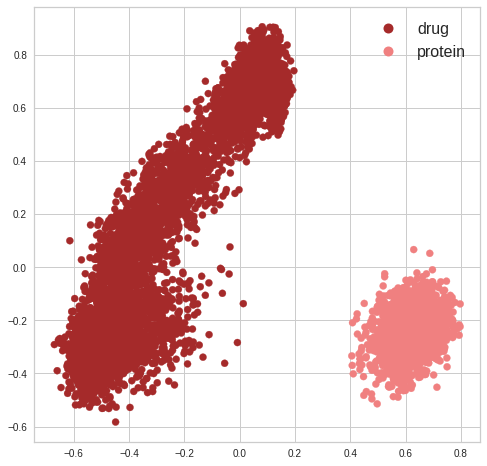

In [7]:
Auxiliary.plot_two_classes(new_df, drug, protein, 'drug', 'protein')

In [ ]:
new_df.to_csv('dataset/embedding_TransH1.csv', index=None)

## Select the optimal number of clusters
#### elbow: By default, the distortion score is computed, the sum of square distances from each point to its assigned center. 

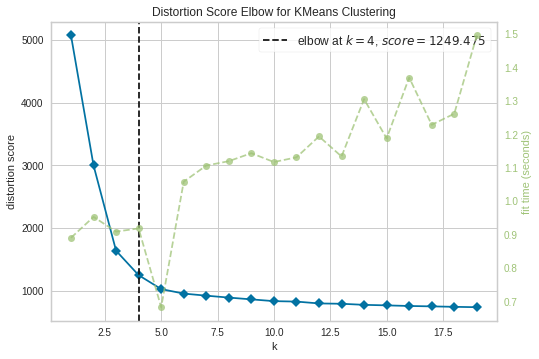

In [10]:
num_cls = Auxiliary.elbow_KMeans(df_predicted_entities, 1, 20)

## Visualize PCA Projection to 2D

/media/rivas/Data1/Projects/Project_Scientific_DB_Programming/Embedding/Auxiliary.py:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['cluster'] = kmeans.fit_predict(new_df)
/media/rivas/Data1/Projects/Project_Scientific_DB_Programming/Embedding/Auxiliary.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['c'] = new_df.cluster.map(color_dictionary)


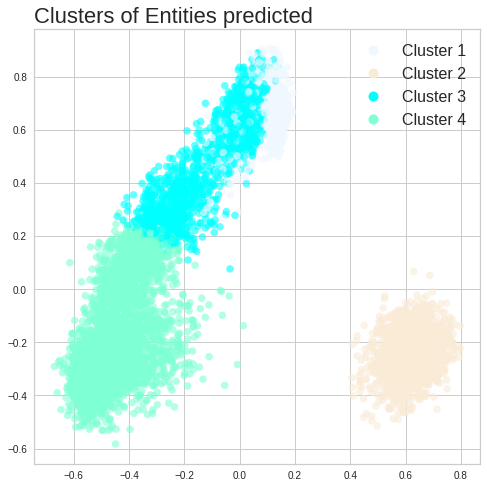

In [11]:
Auxiliary.plot_cluster(num_cls, df_predicted_entities, num_cls)

In [8]:
dpi = list(kg.loc[(kg[1]=='type') & (kg[2]=='DPI')][0].values)
ddi = list(kg.loc[(kg[1]=='type') & (kg[2]=='DDI')][0].values)
node = dpi + ddi

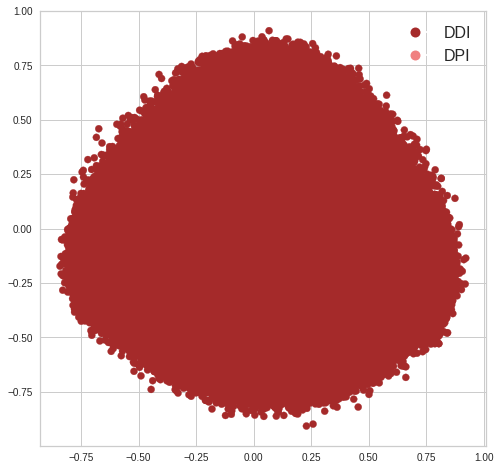

In [9]:
df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, node, tf_dataset)
Auxiliary.plot_two_classes(new_df, ddi, dpi, 'DDI', 'DPI')

In [9]:
d = list(kg.loc[(kg[1]=='type') & (kg[2]=='Drug')][0].values)
p = list(kg.loc[(kg[1]=='type') & (kg[2]=='Protein')][0].values)
node = node + d + p

df_predicted_entities, new_df = Auxiliary.create_dataframe_predicted_entities(entity_embedding_tensor, node, tf_dataset)

In [35]:
new_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,target,cls
16386,0.015604,-0.012068,-0.407369,-0.002924,-0.014521,0.017703,0.048136,-0.174204,-0.035044,0.000425,...,0.025610,-0.027626,-0.043216,-0.421616,-0.295124,0.026906,-0.019412,-0.017844,DB00001-P00734,
16387,-0.009478,-0.031992,-0.389054,-0.017667,-0.022381,-0.023773,0.024153,-0.163061,0.014316,-0.012272,...,0.000815,-0.026025,-0.028656,-0.402554,-0.279302,-0.025717,-0.031979,-0.025521,DB00002-O75015,
16388,0.026936,0.023919,-0.391840,0.002487,0.016471,-0.003915,-0.002574,-0.175444,0.007179,0.019264,...,0.003601,0.022692,0.012192,-0.400345,-0.289663,-0.023277,0.004815,-0.019616,DB00002-P00533,
16389,-0.005977,0.012237,-0.391311,-0.002769,-0.004672,0.003636,0.011289,-0.168150,-0.000654,0.004267,...,-0.007724,-0.002875,-0.005561,-0.403950,-0.284255,0.007861,-0.002529,0.003456,DB00002-P00736,
16390,-0.032798,0.012896,-0.408040,-0.015712,-0.032566,-0.005708,-0.005054,-0.199898,-0.021870,-0.027266,...,-0.021804,-0.025503,0.004975,-0.418118,-0.297434,-0.023728,-0.028887,-0.017269,DB00002-P02745,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664129,0.024346,0.000299,-0.359819,0.028799,0.027193,-0.018203,-0.000695,-0.156215,0.010108,0.017915,...,-0.006966,-0.006518,-0.017591,-0.391756,-0.290551,-0.006042,0.023533,0.008869,Protein:Q9Y6M9,
664130,0.000986,0.007008,-0.366351,-0.027650,-0.032931,-0.001423,-0.026292,-0.164047,0.006196,0.014337,...,-0.015500,-0.007730,0.022851,-0.387164,-0.278378,0.010354,0.004718,-0.019778,Protein:Q9Y6R1,
664131,-0.005963,-0.002741,-0.360127,0.005735,-0.011436,0.010800,0.012332,-0.159338,0.002167,-0.038022,...,-0.012842,-0.039727,0.008887,-0.364198,-0.266521,-0.011191,-0.041028,-0.041784,Protein:Q9Y6Y9,
664132,-0.033160,-0.033070,-0.364688,-0.025088,-0.020328,-0.053868,-0.013178,-0.151532,-0.067456,-0.070626,...,-0.056078,-0.033554,-0.057742,-0.404142,-0.280334,-0.061483,-0.002471,-0.043590,Protein:Q9Z4J7,


In [11]:
entity_type = kg.loc[kg[1]=='type']
entity_type = dict(entity_type[[0,2]].values)
entity_type

{'DB00001-P00734': 'DPI',
 'DB00006-P00734': 'DPI',
 'DB00025-P00734': 'DPI',
 'DB00055-P00734': 'DPI',
 'DB00100-P00734': 'DPI',
 'DB00170-P00734': 'DPI',
 'DB00278-P00734': 'DPI',
 'DB01123-P00734': 'DPI',
 'DB01766-P00734': 'DPI',
 'DB01767-P00734': 'DPI',
 'DB02193-P00734': 'DPI',
 'DB02351-P00734': 'DPI',
 'DB02723-P00734': 'DPI',
 'DB03136-P00734': 'DPI',
 'DB03159-P00734': 'DPI',
 'DB03847-P00734': 'DPI',
 'DB03865-P00734': 'DPI',
 'DB04136-P00734': 'DPI',
 'DB04591-P00734': 'DPI',
 'DB04722-P00734': 'DPI',
 'DB04786-P00734': 'DPI',
 'DB04898-P00734': 'DPI',
 'DB06695-P00734': 'DPI',
 'DB06838-P00734': 'DPI',
 'DB06841-P00734': 'DPI',
 'DB06845-P00734': 'DPI',
 'DB06850-P00734': 'DPI',
 'DB06853-P00734': 'DPI',
 'DB06854-P00734': 'DPI',
 'DB06858-P00734': 'DPI',
 'DB06859-P00734': 'DPI',
 'DB06861-P00734': 'DPI',
 'DB06865-P00734': 'DPI',
 'DB06866-P00734': 'DPI',
 'DB06868-P00734': 'DPI',
 'DB06869-P00734': 'DPI',
 'DB06878-P00734': 'DPI',
 'DB06911-P00734': 'DPI',
 'DB06919-P0

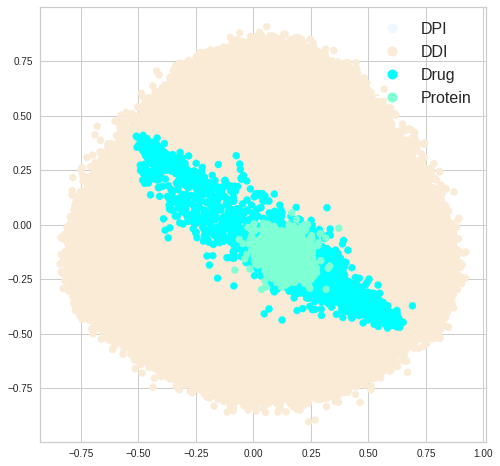

In [12]:
Auxiliary.plot_KGE(new_df, entity_type)